# Spectrum xAI

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

c:\Users\ismoi\anaconda3\envs\ai\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
CLASS = 1
IMAGE_PATH = f"data/dataset/Class{CLASS}/"

In [3]:
class DAGMDataset(Dataset):
    def __init__(self, root_dir, split="Train", transform=None):
        """
        Args:
            root_dir (str): Chemin du dossier dataset.
            split (str): "Train" ou "Test".
            transform (callable, optional): Transformation appliquée aux images.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.data = []
        
        img_dir = os.path.join(root_dir, split)
        label_dir = os.path.join(img_dir, "Label")
        
        images = [f for f in os.listdir(img_dir) if f.endswith((".PNG"))]
        
        for img_name in images:
            img_path = os.path.join(img_dir, img_name)
            label_path = os.path.join(label_dir, img_name.replace(".PNG", "_label.PNG"))
            
            label = 1 if os.path.exists(label_path) else 0
            
            self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Train", transform=transform)
test_dataset = DAGMDataset(root_dir=IMAGE_PATH, split="Test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 575
Test dataset size: 575


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights="DEFAULT").to(device)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


Epoch [1/10], Loss: 0.9089, Train Accuracy: 46.4348


100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Epoch [2/10], Loss: 0.7538, Train Accuracy: 94.0870


100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


Epoch [3/10], Loss: 0.6701, Train Accuracy: 99.8261


100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


Epoch [4/10], Loss: 0.6584, Train Accuracy: 99.8261


100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


Epoch [5/10], Loss: 0.6508, Train Accuracy: 100.0000


100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


Epoch [6/10], Loss: 0.6526, Train Accuracy: 99.4783


100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Epoch [7/10], Loss: 0.6513, Train Accuracy: 99.4783


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


Epoch [8/10], Loss: 0.6486, Train Accuracy: 99.8261


100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


Epoch [9/10], Loss: 0.6474, Train Accuracy: 99.6522


100%|██████████| 18/18 [00:25<00:00,  1.44s/it]

Epoch [10/10], Loss: 0.6452, Train Accuracy: 100.0000


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(weights="DEFAULT").to(device)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
).to(device)
model.load_state_dict(torch.load("model_densenet121_class1.pth"))

<All keys matched successfully>

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float32)
        outputs = model(images).squeeze()
        
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 100.00%


In [9]:
def show_grad_cam(model, image: torch.Tensor, conv_layer_index) -> None:
    """Shows Grad-CAM heatmap for the prediction of an input image using the last conv layer of DenseNet.

    Parameters
    ----------
    image : torch.Tensor
        Image used for Grad-CAM.
    model : torch.nn.Module
        The trained DenseNet model.
    device : torch.device
        Device (CPU/GPU) on which the model is running.

    Returns
    -------
    None
    """
    
    gradients = []
    activations = []

    # Define hooks to extract gradients and activations
    def forward_hook(module, input, output):
        activations.append(output.clone())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].clone())
        
    # Select the last convolutional layer of DenseNet
    layer = model.features[conv_layer_index]  # Last conv layer in DenseNet-121

    # Register hooks
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    # Forward pass
    model.eval()
    image = image.to(device) # Add batch dimension
    output = model(image)
    prob = torch.sigmoid(output).item()  # Convert logits to probability
    
    # Define target class (since binary classification: only one neuron)
    target = output[0, 0]

    # Backward pass to get gradients
    model.zero_grad()
    gradients.clear()
    target.backward()

    # Get activation maps & gradients
    act = activations[0].detach()
    grad = gradients[0].detach()

    # Compute weights for Grad-CAM
    weights = grad.mean(dim=[2, 3], keepdim=True)
    gradcam = F.relu((weights * act).sum(dim=1)).squeeze(0)
    
    # Normalize Grad-CAM
    gradcam -= gradcam.min()
    gradcam /= gradcam.max()
    
    # Resize heatmap to match input image size
    gradcam_resized = cv2.resize(gradcam.cpu().numpy(), (image.shape[2], image.shape[3]))

    # Plot the result
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.cpu().squeeze().permute(1, 2, 0))  # Original image
    ax[0].set_title("Input Image")

    ax[1].imshow(image.cpu().squeeze().permute(1, 2, 0))  # Overlay Grad-CAM
    ax[1].imshow(gradcam_resized, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Grad-CAM (Defective Prob: {prob*100:.1f}%)")

    plt.show()

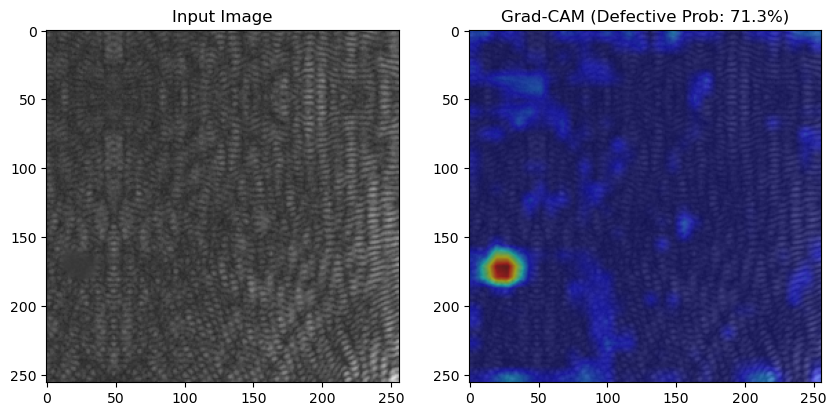

1


In [17]:
index = 9
image, label = test_dataset[index][0].unsqueeze(0), test_dataset[index][1]
show_grad_cam(model, image, 6)
print(label)